Here our goal is to reduce the energy as much as possible, at the same time keep track of the cost.

### Imports

In [21]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import *

import matplotlib.pyplot as plt

### Help functions

In [29]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)
    
def gradient_numerical_Ising(
    loss_function,
    b_params: list,
    j_params: list,
    loss_0,
    s_0,
    delta: float = 1e-3,
):
    grad_b = np.zeros(len(b_params))
    grad_j = np.zeros(len(j_params))
    for i in range(len(b_params)):
        params_new = deepcopy(b_params)
        params_new[i] += delta
        eo_d = IsingNNEvolutionOracle(params_new, j_params)
        # find the increment of a very small step
        grad_b[i] = (loss_function(s_0, eo_d) - loss_0 ) / delta
    for i in range(len(j_params)):
        params_new = deepcopy(j_params)
        params_new[i] += delta
        eo_d = IsingNNEvolutionOracle(b_params, params_new)
        # find the increment of a very small step
        grad_j[i] = (loss_function(s_0, eo_d) - loss_0 ) / delta
    return grad_b, grad_j

def grid_search_Ising(loss_function, b_list, j_list, grad_b, grad_j, s_min, s_max, lr_min, lr_max, max_eval):
    # Calculate the number of points in the grid based on max_eval
    n_points = int(np.sqrt(max_eval))
    
    # Generate grid of parameters
    s_values = np.linspace(s_min, s_max, n_points)
    lr_values = np.linspace(lr_min, lr_max, n_points)
    
    best_loss = float('inf')
    best_s = None
    best_lr = None
    
    # Iterate over all combinations of s and lr
    for s in s_values:
        for lr in lr_values:
            b_eval = deepcopy(b_list)
            j_eval = deepcopy(j_list)
            b_eval = b_eval - grad_b * lr
            j_eval = j_eval - grad_j * lr
            eo_d = IsingNNEvolutionOracle(b_eval, j_eval)
            # Evaluate the loss function with the current parameters
            loss = loss_function(s, eo_d)
            
            # Update the best parameters if the current loss is lower
            if loss < best_loss:
                best_loss = loss
                best_s = s
                best_lr = lr
        best_params = (b_list - grad_b * best_lr, j_list - grad_j * best_lr)
    return best_s, best_lr, best_params, best_loss

## Load VQE

In [5]:
qibo.set_backend("numpy")

# set the path string which define the results
path = "../results/vqe_data/with_params/sgd_10q_7l_42/"

# set the target epoch to which apply DBQA and the number of steps
target_epoch = 2000
dbi_steps = 1

# upload system configuration and parameters for all the training
with open(path + "optimization_results.json") as file:
    config = json.load(file)

losses = dict(np.load(path + "energies.npz"))["0"]
params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

nqubits = config["nqubits"]
# build circuit, hamiltonian and VQE
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
circuit = build_circuit(nqubits, config["nlayers"], "numpy")
vqe = VQE(circuit, hamiltonian)
zero_state = hamiltonian.backend.zero_state(nqubits)
zero_state_t = np.transpose([zero_state])
target_energy = np.min(hamiltonian.eigenvalues())


# set target parameters into the VQE
vqe.circuit.set_parameters(params)
vqe_state = vqe.circuit().state()

ene1 = hamiltonian.expectation(vqe_state)

[Qibo 0.2.9|INFO|2024-06-14 15:25:22]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-14 15:25:23]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy


In [123]:
print(f"VQE energy is {ene1}. \n\
The target energy is {target_energy} which means the difference is {ene1-target_energy}.\n\
The relative difference is {abs(ene1-target_energy)/abs(target_energy)*100}%.\n\
The goal is to reach 1.0% which requires to lower energy to {0.99*target_energy}.")

VQE energy is -14.856898957126571. 
The target energy is -15.276131122065761 which means the difference is 0.41923216493919035.
The relative difference is 2.744360869838478%.
The goal is to reach 1.0% which requires to lower energy to -15.123369810845103.


## 1. Try reduced GCI

In [124]:
# Initialize transpiler code
eo_xxz = XXZ_EvolutionOracle(nqubits, steps = 1, order = 2)

# implement the rotate by VQE on the level of circuits
fsoe  = VQERotatedEvolutionOracle(eo_xxz, vqe)

# init gci with the vqe-rotated hamiltonian
gci  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced)

In [125]:
# Randomized initial b_list
# 1-local magnetic field
b_list = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,0,10))]
eo_d = MagneticFieldEvolutionOracle(b_list)
# 2-local Ising model
eo_d_Ising = IsingNNEvolutionOracle(b_list,b_list)

([<matplotlib.axis.XTick at 0x298fc5890>],
 [Text(0.011555555555555555, 0, '0.01156')])

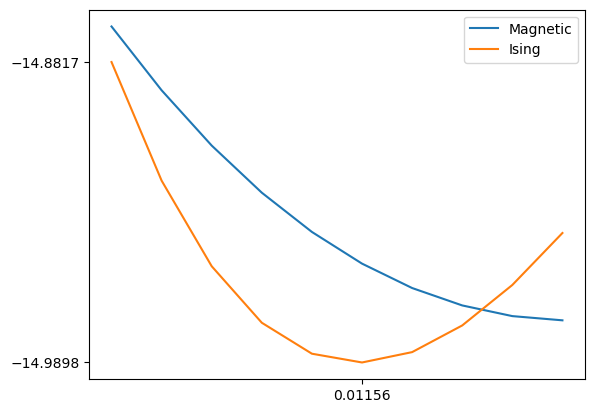

In [126]:
losses_1 = []
losses_2 = []
times = np.linspace(1e-3,2e-2,10)
for s in times:
    losses_1.append(gci.loss(s, eo_d))
    losses_2.append(gci.loss(s, eo_d_Ising))
plt.plot(times,losses_1, label="Magnetic")
plt.plot(times,losses_2, label="Ising")
plt.legend()
plt.yticks([losses_1[0],losses_1[np.argmin(losses_1)]])
plt.xticks([times[np.argmin(losses_1)]])
plt.yticks([losses_2[0],losses_2[np.argmin(losses_2)]])
plt.xticks([times[np.argmin(losses_2)]])

In [127]:
min_loss = min(losses_2)
s_gci_1 = times[np.argmin(losses_2)]
print(f"The minimum energy is achieved by Ising model at {min_loss},\n\
The relative difference is now {abs(ene1-target_energy)/abs(target_energy)*100}%.")

The minimum energy is achieved by Ising model at -14.989844866828316,
The relative difference is now 2.744360869838478%.


To further lower the energy, we try a step of gradient descent.

In [128]:
grad_b, grad_j = gradient_numerical_Ising(gci.loss, b_list, b_list, min_loss, s_gci_1 )
print(grad_b, grad_j)

[ 1.69287691e-03  1.14889580e-03  9.10209199e-04 -9.68637384e-05
 -1.07337659e-05 -1.23843417e-03 -1.27076022e-03 -3.05051791e-03
 -2.70961964e-03 -4.14654275e-03] [ 2.28574623e-03  8.66741212e-04  5.51505977e-04 -6.87671058e-05
 -9.41078827e-04 -2.18244792e-03 -1.72849639e-03 -2.23616210e-03
 -3.69326350e-03 -4.22770045e-03]


In [144]:
best_s, best_lr, best_params, best_loss = grid_search_Ising(gci.loss, b_list, b_list, grad_b, grad_j, 5e-3, 5e-2, 1e2, 5e2, 300)
print(f"The first gradient descent step reduces energy to {best_loss}, a difference of {best_loss - min_loss}.")
print(best_s, best_lr)
b_list_train = best_params[0]
j_list_train = best_params[1]
best_loss_train = best_loss
best_s_train = best_s

The first gradient descent step reduces energy to -14.995518008675015, a difference of -0.0056731418466995365.
0.0078125 100.0


In [139]:
# Training gradient
train_epochs = 10
for _ in range(train_epochs):
    grad_b_train, grad_j_train = gradient_numerical_Ising(gci.loss, b_list_train, j_list_train, best_loss_train, best_s_train )
    best_s_train, best_lr_train, best_params_train, best_loss_train = grid_search_Ising(gci.loss, b_list_train, j_list_train, grad_b_train, grad_j_train,  5e-3, 5e-2, 1e2, 5e2, 100)
    b_list_train = best_params_train[0]
    j_list_train = best_params_train[1]
    if best_loss_train < best_loss:
        best_loss = best_loss_train
        best_s = best_s_train
        best_params = best_params_train
    if best_loss_train > -14.98:
        break
    print(best_loss)

Gradient descent training reached paleau at the second step, we move on to the second step

## 2. 2nd Step

In [145]:
b_list, j_list = best_params
eo_d_Ising = IsingNNEvolutionOracle(b_list,j_list)
print(gci.loss(best_s, eo_d_Ising))
c0 = gci.group_commutator(best_s, eo_d_Ising)["forwards"]
c1 = gci.get_composed_circuit()
v1_circ = c0+c1
hamiltonian.expectation((v1_circ)().state())

-14.995518008675015


-14.995518008675017

In [146]:
fsoe2  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v1_circ.invert(), after_circuit=v1_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe2, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced)
gci2.print_gate_count_report()
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
gci2.loss()

The boosting circuit used 90 CNOT gates coming from compiled XXZ evolution and 350 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 9.0 and n_CZ/n_qubits = 35.0


-14.995518008675015

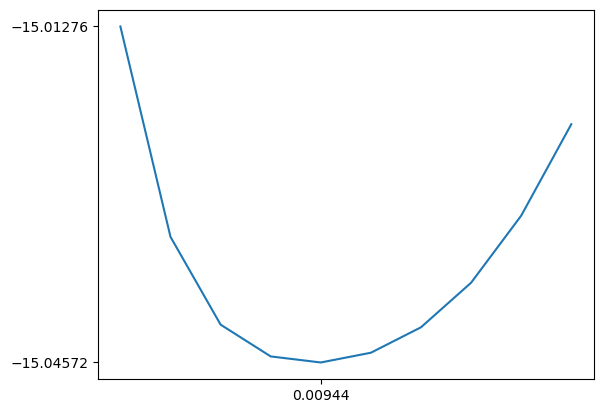

In [147]:
gci2.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
losses = []
times = np.linspace(1e-3,2e-2,10)
eo_d_Ising = IsingNNEvolutionOracle(b_list, j_list)
for s in times:
    losses.append(gci2.loss(s, eo_d_Ising))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
initial_loss = min(losses)
s_gci_2nd = times[np.argmin(losses)]

Repeat the steps with gradient descent.

### Gradient descent

In [148]:
grad_b, grad_j = gradient_numerical_Ising(gci2.loss, b_list, j_list, initial_loss, s_gci_2nd )
print(grad_b, grad_j)

[-0.0001593  -0.0003494  -0.00026101 -0.00069051 -0.00036367 -0.00019519
 -0.00069194 -0.0002644  -0.00018128 -0.0004412 ] [-0.00026579 -0.00044557 -0.00047773 -0.0010062  -0.0006198  -0.00072631
 -0.00112734 -0.00028637 -0.00053224 -0.00055129]


In [159]:
best_s, best_lr, best_params, best_loss = grid_search_Ising(gci2.loss, b_list, b_list, grad_b, grad_j, 5e-3, 2e-2, 1e2, 1e3, 100)
print(f"The first gradient descent step reduces energy to {best_loss}, a difference of {best_loss - initial_loss}.")
print(best_s, best_lr)
b_list_train = best_params[0]
j_list_train = best_params[1]
best_loss_train = best_loss
best_s_train = best_s

The first gradient descent step reduces energy to -15.047227216277397, a difference of -0.0015083238347948225.
0.008333333333333333 500.0


### Gradient training

In [160]:
# Training gradient
train_epochs = 5
for _ in range(train_epochs):
    grad_b_train, grad_j_train = gradient_numerical_Ising(gci2.loss, b_list_train, j_list_train, best_loss_train, best_s_train )
    best_s_train, best_lr_train, best_params_train, best_loss_train = grid_search_Ising(gci2.loss, b_list_train, j_list_train, grad_b_train, grad_j_train, 5e-3, 2e-2, 1e2, 1e3, 30)
    b_list_train = best_params_train[0]
    j_list_train = best_params_train[1]
    if best_loss_train < best_loss:
        best_loss = best_loss_train
        best_s = best_s_train
        best_params = best_params_train
    if best_loss_train > np.round(initial_loss):
        break
    print(best_loss)

-15.047549462419939
-15.047764944101074
-15.04792690550585
-15.048038046105933
-15.048099010507396


## 3. 3rd step

In [161]:
b_list, j_list = best_params
eo_d_Ising = IsingNNEvolutionOracle(b_list,j_list)
print(gci2.loss(best_s, eo_d_Ising))
c0 = gci2.group_commutator(best_s, eo_d_Ising)["forwards"]
c1 = gci2.get_composed_circuit()
v2_circ = c0+c1
hamiltonian.expectation((v2_circ)().state()) 

-15.048099010507396


-15.048099010507396

In [162]:
fsoe3  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v2_circ.invert(), after_circuit=v2_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci3  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe3, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced)
gci3.print_gate_count_report()
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
gci3.loss()

The boosting circuit used 540 CNOT gates coming from compiled XXZ evolution and 1750 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 54.0 and n_CZ/n_qubits = 175.0


-15.048099010507396

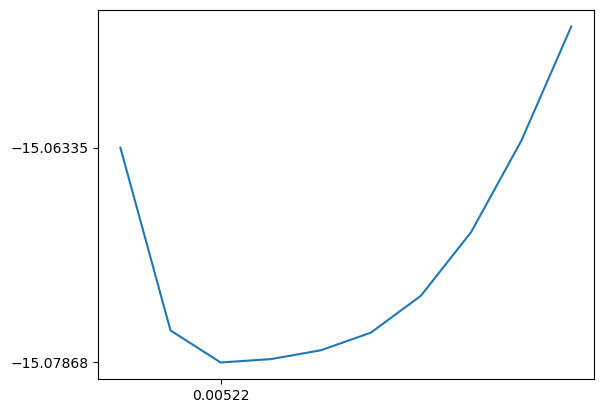

In [163]:
gci3.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
losses = []
times = np.linspace(1e-3,2e-2,10)
eo_d_Ising = IsingNNEvolutionOracle(b_list, j_list)
for s in times:
    losses.append(gci3.loss(s, eo_d_Ising))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
initial_loss = min(losses)
s_gci_3rd = times[np.argmin(losses)]

### Gradient descent

In [164]:
grad_b, grad_j = gradient_numerical_Ising(gci3.loss, b_list, j_list, initial_loss, s_gci_3rd )
print(grad_b, grad_j)

[-0.00021945 -0.00033477 -0.00035416 -0.0005305  -0.00048769 -0.00032455
 -0.00043283 -0.0003387  -0.0002082  -0.00039806] [-0.00040381 -0.00047986 -0.00058137 -0.00070244 -0.00054989 -0.00055154
 -0.00059134 -0.00037207 -0.00039661 -0.00056224]


In [166]:
best_s, best_lr, best_params, best_loss = grid_search_Ising(gci3.loss, b_list, b_list, grad_b, grad_j, 1e-3, 1e-2, 1e2, 2e3, 100)
print(f"The first gradient descent step reduces energy to {best_loss}, a difference of {best_loss - initial_loss}.")
print(best_s, best_lr)
b_list_train = best_params[0]
j_list_train = best_params[1]
best_loss_train = best_loss
best_s_train = best_s

The first gradient descent step reduces energy to -15.082669061819992, a difference of -0.0039861920947643625.
0.005 1788.888888888889


### Gradient training

In [172]:
# Training gradient
train_epochs = 1
for _ in range(train_epochs):
    grad_b_train, grad_j_train = gradient_numerical_Ising(gci2.loss, b_list_train, j_list_train, best_loss_train, best_s_train )
    best_s_train, best_lr_train, best_params_train, best_loss_train = grid_search_Ising(gci2.loss, b_list_train, j_list_train, grad_b_train, grad_j_train, 1e-3, 3e-2, 1e1, 1e2, 30)
    b_list_train = best_params_train[0]
    j_list_train = best_params_train[1]
    if best_loss_train < best_loss:
        best_loss = best_loss_train
        best_s = best_s_train
        best_params = best_params_train
    if best_loss_train > np.round(initial_loss):
        break
    print(best_loss)

In [173]:
print(grad_b_train, grad_j_train, best_lr_train, best_s_train)

[0.00044688 0.00049679 0.00068806 0.00078858 0.00070354 0.00070705
 0.00076442 0.00081346 0.0006076  0.00075727] [0.00043722 0.00079801 0.00066789 0.00071422 0.00067625 0.00074009
 0.00073627 0.00069744 0.0005468  0.00082511] 100.0 0.001
